In [1]:
import numpy as np #rename the library to np for convenience
import matplotlib.pyplot as plt #we want the "pyplot" module
import math
#allows plots to display in the notebook instead of another window
%matplotlib inline
print('Libraries successfully imported!')

Libraries successfully imported!


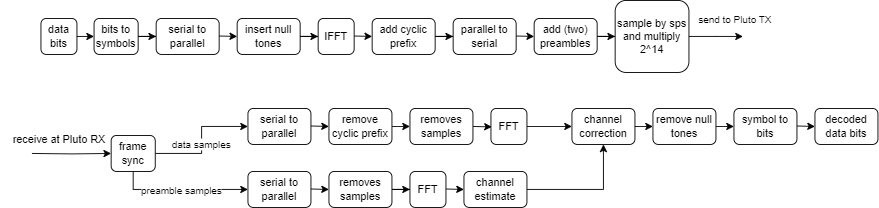

In [2]:
# set up OFDM subcarriers 
N = 64 # total number of OFDM subcarriers (data and null carriers)
CP_length = 8 #length of cyclic prefix

#define which carriers transmit null tones and which contains payload
allCarriers = np.arange(N) #indices of all subcarriers ([0,1,...,N-1])
nullCarriers = [0,30,30,30] #indices of all null carriers, error in later steps --> this will give nullCarriers = [0,31,32,33]

K = len(nullCarriers) # number of null subcarriers
dataCarriers = np.delete(allCarriers, [0,31,32,33]) #indices of all data carriers 
print("There are ", len(allCarriers), " total carriers with", len(dataCarriers), "data carriers and ", len(nullCarriers), " null carriers")
print("Null Carriers are ", [0,31,32,33])
print("Data Carriers are ", dataCarriers)


There are  64  total carriers with 60 data carriers and  4  null carriers
Null Carriers are  [0, 31, 32, 33]
Data Carriers are  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63]


Modulation type: four_QAM 
number of bits per symbol: 2 
number of payload bits per OFDM symbol: 120


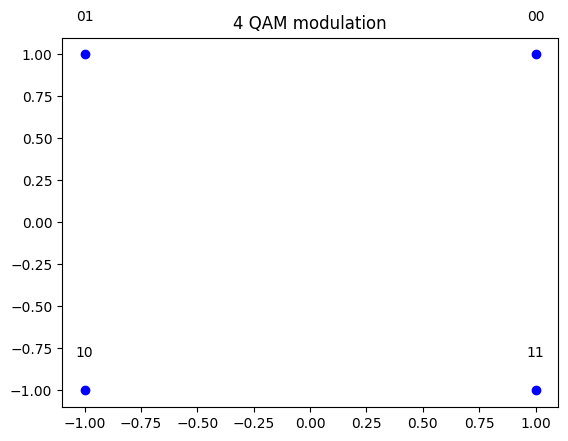

In [3]:
# set up modulation type
modulationType = "four_QAM" #change to either four_QAM or sixteen_QAM - ONLY CHANGE THIS LINE!!!


# 4 QAM
def four_QAM():
    mu = 2 # number of bits per symbol 
    payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol
    mapping_table = {
        (0,0): 1+1j,
        (0,1): -1+1j,
        (1,0): -1-1j,
        (1,1): 1-1j
    }

    for b1 in [0, 1]:
        for b0 in [0, 1]:
            B = (b1, b0)
            Q = mapping_table[B]
            plt.title("4 QAM modulation")
            plt.plot(Q.real, Q.imag, 'bo')
            plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
    return mu, payloadBits_per_OFDM, mapping_table
    
# 16 QAM
def sixteen_QAM():
    mu = 4 # number of bits per symbol 
    payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol
    mapping_table = {
        (0,0,0,0) : -3+3j,
        (0,0,0,1) : -3+1j,
        (0,0,1,0) : -3-3j,
        (0,0,1,1) : -3-1j,
        (0,1,0,0) : -1+3j,
        (0,1,0,1) : -1+1j,
        (0,1,1,0) : -1-3j,
        (0,1,1,1) : -1-1j,
        (1,0,0,0) :  3+3j,
        (1,0,0,1) :  3+1j,
        (1,0,1,0) :  3-3j,
        (1,0,1,1) :  3-1j,
        (1,1,0,0) :  1+3j,
        (1,1,0,1) :  1+1j,
        (1,1,1,0) :  1-3j,
        (1,1,1,1) :  1-1j
    }
    for b3 in [0, 1]:
        for b2 in [0, 1]:
            for b1 in [0, 1]:
                for b0 in [0, 1]:
                    B = (b3, b2, b1, b0)
                    Q = mapping_table[B]
                    plt.title("16 QAM modulation")
                    plt.plot(Q.real, Q.imag, 'bo')
                    plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
    return mu, payloadBits_per_OFDM, mapping_table

if modulationType == "four_QAM":
    mu, payloadBits_per_OFDM, mapping_table = four_QAM()

elif modulationType == "sixteen_QAM":
    mu, payloadBits_per_OFDM, mapping_table = sixteen_QAM()

else:
    print("invalid modulation type")

print("Modulation type:", modulationType, "\nnumber of bits per symbol: "+str(mu)+" \nnumber of payload bits per OFDM symbol: "+str(payloadBits_per_OFDM))
demapping_table = {v: k for k, v in mapping_table.items()} #used for demapping later on 

In [4]:

# set up random bit sequence
num_packets = 1 #number of OFDM packets to be transmitted
bits = np.random.randint(0, 2, size=(num_packets*payloadBits_per_OFDM)) # how many bits to be transmitted
print("bits = ", bits)
print("length of bits = ", len(bits))



# convert to symbol, x-QAM modulation scheme
def SP(bits):
    return bits.reshape(len(bits)//mu, mu)
bits_SP = SP(bits)

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)

print("QAM = ", QAM)



# convert serial to parallel 
def s_to_p(QAM):
    rows = (math.ceil(len(QAM)/len(dataCarriers)))
    cols = (len(dataCarriers))
    arr_sizes = rows * cols
    
    QAM_sp = np.pad(QAM, pad_width = (0,arr_sizes - len(QAM)))
    return rows, cols, QAM_sp.reshape(rows, cols)

rows, cols, QAM_reshaped = s_to_p(QAM) 
print("rows = ", rows)
print("cols (before inserting null tone) = ", cols)



#insert null tones
OFDM_data = np.zeros((rows, N), dtype=complex)
OFDM_data = np.insert(QAM_reshaped, nullCarriers, 0, axis=1)
print(OFDM_data)


print("after inserting null tone", np.shape(OFDM_data))
cols = len(OFDM_data[0]) # new # of columns should equal N
print("new # of columns ", cols)

#exceptions
if len(OFDM_data[0]) != N:
    raise Exception("Error converting serial to parallel. Check that the amount of bits transmitted is an integer multiple of the amount of bits in an OFDM packet", N)

#########################################

#create OFDM preamble
pre = np.random.randint(0, 2, size=(payloadBits_per_OFDM)) #preamble is 1 packet long
pre_SP = SP(pre)
pre_QAM = Mapping(pre_SP)



#insert null tones to preamble
OFDM_preamble = np.insert(pre_QAM, nullCarriers, 0)

print("pream with null tones:", OFDM_preamble)


bits =  [1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0
 0 1 0 0 0 0 1 0 0]
length of bits =  120
QAM =  [ 1.-1.j  1.+1.j -1.+1.j -1.+1.j -1.-1.j -1.+1.j -1.-1.j -1.+1.j -1.+1.j
 -1.-1.j  1.+1.j -1.+1.j  1.+1.j -1.-1.j  1.-1.j -1.+1.j  1.-1.j  1.+1.j
  1.-1.j -1.+1.j  1.+1.j -1.+1.j  1.+1.j -1.-1.j  1.+1.j  1.-1.j  1.-1.j
 -1.+1.j -1.-1.j -1.+1.j  1.+1.j  1.+1.j -1.+1.j -1.-1.j  1.+1.j -1.-1.j
 -1.-1.j  1.-1.j -1.+1.j -1.+1.j  1.-1.j -1.+1.j  1.+1.j  1.+1.j -1.+1.j
  1.-1.j  1.-1.j -1.+1.j -1.+1.j -1.-1.j  1.+1.j  1.-1.j  1.-1.j  1.-1.j
  1.+1.j  1.+1.j -1.-1.j  1.+1.j -1.+1.j  1.+1.j]
rows =  1
cols (before inserting null tone) =  60
[[ 0.+0.j  1.-1.j  1.+1.j -1.+1.j -1.+1.j -1.-1.j -1.+1.j -1.-1.j -1.+1.j
  -1.+1.j -1.-1.j  1.+1.j -1.+1.j  1.+1.j -1.-1.j  1.-1.j -1.+1.j  1.-1.j
   1.+1.j  1.-1.j -1.+1.j  1.+1.

In [5]:
#IFFT (convert data and preamble to time domain)
OFDM_time = np.fft.ifft2(OFDM_data)
OFDM_preamble_time = np.fft.ifft(OFDM_preamble)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))



cps = [] #keep track of the cyclic prefixes of each data packet
#add cyclic prefix to data 
def addCP(OFDM_time):
    OFDM_CP = np.zeros((rows, N+CP_length), dtype=complex)
    for i in range(rows):
        cp = OFDM_time[i][-CP_length:] #take the last "CP" amount of values
        cps.append(cp)
        OFDM_CP[i] = np.hstack([cp, OFDM_time[i]])
    return OFDM_CP, cp #put them in the front of array

print("added last ", CP_length, "elements to front of array for cyclic prefix")
OFDM_CP, cp = addCP(OFDM_time) 
print("cyclic prefix for data", cps)

#add cyclic prefix for preamble
preamble_cp = OFDM_preamble_time[-CP_length:]
OFDM_preamble_CP = np.append(preamble_cp, OFDM_preamble_time)


#parallel to serial
OFDM_CP_serial = OFDM_CP.flatten()

print(len(OFDM_CP[0]))
print(len(OFDM_CP_serial)) #now the two packets are serialized into one packet

#exceptions
if (len(OFDM_CP[0])*num_packets != len(OFDM_CP_serial)):
    raise Exception("Error converting parallel to serial. Check that the amount of bits transmitted is an integer multiple of the amount of bits in an OFDM packet", N)

Number of OFDM samples in time-domain before CP:  1
added last  8 elements to front of array for cyclic prefix
cyclic prefix for data [array([ 0.07923543-0.31092961j,  0.09225318-0.05269997j,
        0.03105641-0.07458138j, -0.17352122-0.03139113j,
        0.09291469+0.12107778j,  0.09867151+0.17970311j,
        0.00277688+0.2151743j ,  0.03410521+0.07853186j])]
72
72


In [6]:
# append ONE preambles to the data packets (we use TWO preambles so we can average the noise later)
OFDM_w_preamble = np.concatenate((OFDM_preamble_CP, OFDM_CP_serial), 0)

print("length of OFDM_w_preamble", len(OFDM_w_preamble))

#exceptions
if len(OFDM_w_preamble) != (len(OFDM_preamble_CP) + num_packets * (N+CP_length)):
    raise Exception("Error concatenating two preambles with data.")

length of OFDM_w_preamble 144


In [7]:
import adi

#Stop transmitting --> comment out if running for first time, uncomment for later 
# sdr.tx_destroy_buffer()

OFDM_TX = OFDM_w_preamble

#Config first Pluto (E) --> acts as transmitter 
sps = 10 # sample per symbol (to create square pulse)
sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 5*sps*len(OFDM_TX) # number of samples per call to rx(), increase if exception after frame sync
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -20.0 #Increase to increase tx power, valid range is -90 to 0 dB

# Config RX
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = int(num_samps)
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = -20.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC



# #Config second Pluto (F) --> acts as receiver

# sdr2 = adi.Pluto("ip:192.168.3.1")
# sdr2.sample_rate = int(sample_rate)


# # Config Rx
# sdr2.rx_lo = int(center_freq)
# sdr2.rx_rf_bandwidth = int(sample_rate)
# sdr2.rx_buffer_size = int(num_samps)
# sdr2.gain_control_mode_chan0 = 'manual'
# sdr2.rx_hardwaregain_chan0 = -0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC





In [8]:
# Transmit samples
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
OFDM_TX = np.repeat(OFDM_TX, sps) #create square pulse, symbol --> sample
OFDM_TX_send = OFDM_TX* 2**14 # for transmitter range [-2e14,2e14]
sdr.tx(OFDM_TX_send) # start transmitting

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()




In [9]:
# For QPSK Costas Loop 
def phase_detector_4(sample):
    if sample.real > 0:
        a = 1.0
    else:
        a = -1.0
    if sample.imag > 0:
        b = 1.0
    else:
        b = -1.0
    return a * sample.imag - b * sample.real

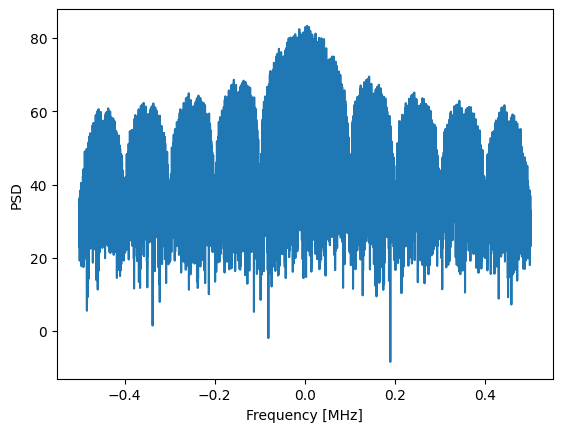

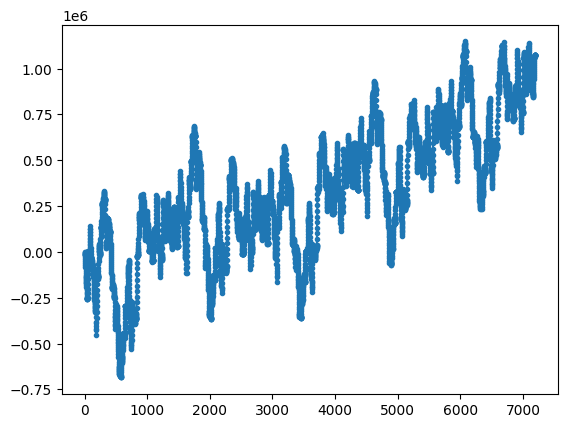

720
k is  667
length of OFDM_RX_shifted 6533


Text(0.5, 1.0, 'after frame sync (freq domain)')

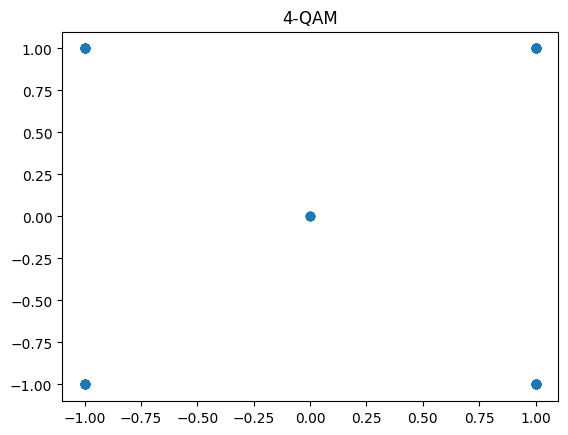

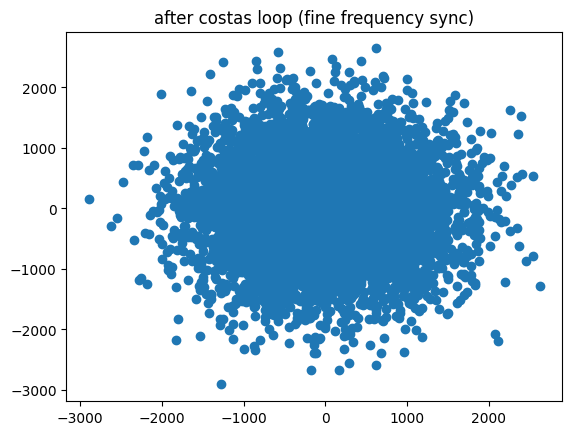

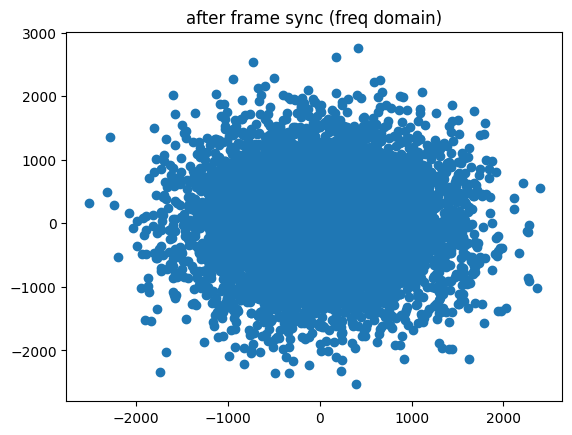

In [21]:
iterations = 1
distances = []
for i in range(iterations):
    
    # Receive samples
    OFDM_RX = sdr.rx()
    
    # Calculate power spectral density (frequency domain version of signal)
    psd = np.abs(np.fft.fftshift(np.fft.fft(OFDM_RX)))**2
    psd_dB = 10*np.log10(psd)
    f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))
    
    # Plot freq domain
    plt.figure(1)
    plt.plot(f/1e6, psd_dB)
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("PSD")
    plt.show()
    
    
    # # coarse frequency 
    # rx_samples_squared = OFDM_RX**2
    # psd = np.abs(np.fft.fftshift((rx_samples_squared)))
    # f = np.linspace(-sample_rate/2.0, sample_rate/2.0, len(psd))
    # plt.plot(f, psd)
    # plt.show()
    
    # max_freq = f[np.argmax(psd)]
    # print("max frequency", max_freq)
    # Ts = 1/sample_rate # calc sample period
    # t = np.arange(0, Ts*num_samps, Ts) # create time vector, i just set to num_samps so it's able to fetch? rn num_samps set to one capture
    # rx_samples = OFDM_RX * np.exp(-1j*2*np.pi*max_freq*t/2.0)
    


    #costas loop -> before frame sync

    phase = 0
    freq = 0
    # These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
    alpha = 0.132
    beta = 0.00932
    rx_out = np.zeros(len(OFDM_RX), dtype=complex)
    freq_log = []
    for i in range(len(OFDM_RX)):
        rx_out[i] = OFDM_RX[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
        error = phase_detector_4((OFDM_RX[i])) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)
    
        # Advance the loop (recalc phase and freq offset)
        freq += (beta * error)
        freq_log.append(freq * sample_rate / (2*np.pi)) # convert from angular velocity to Hz for logging
        phase += freq + (alpha * error)
    
        # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
        while phase >= 2*np.pi:
            phase -= 2*np.pi
        while phase < 0:
            phase += 2*np.pi
    
    # Plot freq over time to see how long it takes to hit the right offset
    plt.plot(freq_log,'.-')
    plt.show()
        
        
        
    



    # frame sync
    one_preamble = np.repeat(OFDM_preamble_CP, sps) #sample the preambles with sps
    
    preamble_length = len(one_preamble)
    print(preamble_length)
    
    
    
    def max_in_arr(arr, n):
        # Initialize maximum element
        max_elem = arr[0]
        max_i = 0
        # Traverse array elements from second
        # and compare every element with
        # current max
        for i in range(1, n):
            if np.linalg.norm(arr[i]) > np.linalg.norm(max_elem):
                max_elem = arr[i]
                max_i = i 
        return max_elem, max_i
    
    #correlate two preambles with received datas
    arr = []
    for i in range(len(OFDM_RX)):
        arr.append(np.correlate(one_preamble, rx_out[i:preamble_length+i]))
        
    flat_arr =[]
    for i in range(len(arr)):
        flat_arr.extend(arr[i])
    
    # find the maximum correlation
    max_corr, k = max_in_arr(flat_arr, len(flat_arr))
    print("k is ", k)
    
    # plt.figure()
    # plt.plot(np.linalg.norm(flat_arr[0:k+200]))
    
    #shift received datas to align with frame sync
    OFDM_RX_shifted = rx_out[k:len(OFDM_RX)+k]
    
    print("length of OFDM_RX_shifted", len(OFDM_RX_shifted))
    
    #exceptions --> this will be the most common, because it completely depends on the channel 
    if len(OFDM_RX_shifted) < (preamble_length+(num_packets*(N+CP_length)*sps)):
        raise Exception("Not enough data captured to decode. Increase num_samps")
        




#all in the time domain? 

#original 
plt.figure()
plt.scatter(np.real(np.fft.fft(OFDM_preamble_time)), np.imag(np.fft.fft(OFDM_preamble_time)))
plt.title("4-QAM")

# #after coarse frequency
# plt.figure()
# plt.scatter(np.real(OFDM_RX), np.imag(OFDM_RX))
# plt.title("received")


#after costas loop
plt.figure()
plt.scatter(np.real(np.fft.fft(rx_out)), np.imag(np.fft.fft(rx_out)))
plt.title("after costas loop (fine frequency sync)")

#after FRAME SYNC
plt.figure()
plt.scatter(np.real(np.fft.fft(OFDM_RX_shifted)), np.imag(np.fft.fft(OFDM_RX_shifted)))
plt.title("after frame sync (freq domain)")
    
    
 
    
 

Text(0.5, 1.0, 'after frame sync (time domain)')

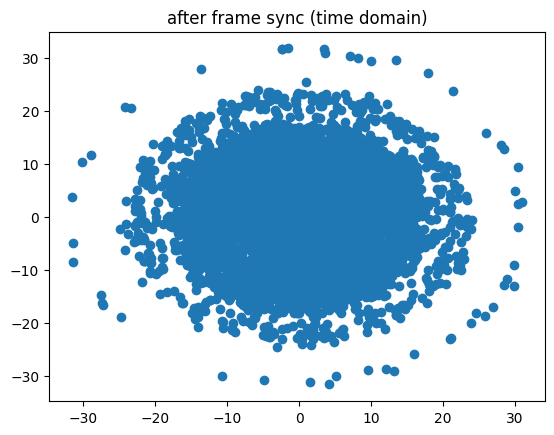

In [22]:
plt.figure()
plt.scatter(np.real((OFDM_RX_shifted)), np.imag((OFDM_RX_shifted)))
plt.title("after frame sync (time domain)")

(720,)
(640,)
after removing sps (64,)
d with null tones nan
average distance is nan
distances are [nan]
delta d is []


C:\Users\Esthe\AppData\Local\Temp\ipykernel_14788\3397477717.py:34: RuntimeWarning: divide by zero encountered in divide
  Hest = OFDM_preamble_received / OFDM_preamble_original


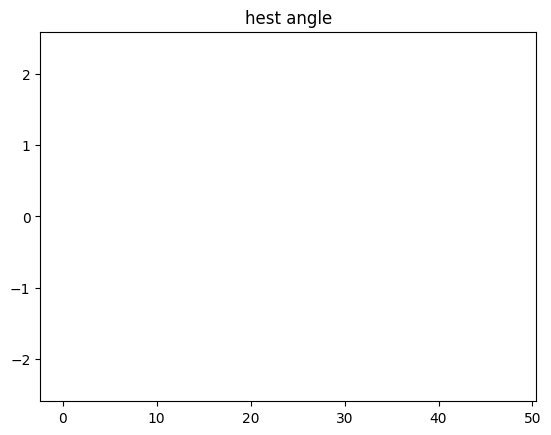

In [23]:
   # channel estimation
for i in range(iterations):
    
    OFDM_RX_preamble = OFDM_RX_shifted[0:preamble_length]
    
    print(np.shape(OFDM_RX_preamble))
    
    
    OFDM_preamble_sample = np.repeat(OFDM_preamble_CP, sps)
    # print("original preamble in time", OFDM_preamble_sample[0:10])
    # print("received preamble in time", OFDM_RX_preamble[0:10])
    
    #exceptions
    if len(OFDM_preamble_sample) != len(OFDM_RX_preamble):
        raise Exception("Original preamble length is not equal to Received preamble length. Check previous exception")
    
    # remove cyclic prefix from preamble
    OFDM_RX_preamble = OFDM_RX_preamble[CP_length*sps:]
    print(np.shape(OFDM_RX_preamble))
    
    # change samples back to symbols using slice
    OFDM_RX_preamble = OFDM_RX_preamble[::sps]
    print("after removing sps", np.shape(OFDM_RX_preamble))
    
    
    # FFT preambles (time->frequency)
    OFDM_preamble_original = np.fft.fft(OFDM_preamble_time)
    OFDM_preamble_received = np.fft.fft(OFDM_RX_preamble)
                
    # print("original preamble in freq", OFDM_preamble_original[0:10])
    # print("received preamble in freq", OFDM_preamble_received[0:10])
    
    #estimate the channel
    Hest = OFDM_preamble_received / OFDM_preamble_original
    # print("Hest", Hest[0:10])
    
    #exception
    if len(Hest) != N:
        raise Exception("Length of Hest is not equal to OFDM packet length N. Check previous exception")
    
    
    # IFFT to time domain
    hest = np.fft.ifft(Hest)
    # print("hest", hest[0:10])
    # test to see that hest is similar when not moving
    plt.figure()
    plt.plot(np.angle(hest))
    plt.title("hest angle")
    
    
    
    # calculate the frequencies
    f_sym = np.floor(sample_rate / sps)
    delta_f = f_sym / N
    
    # use formula to find tau and subsequently d
    f = np.arange(center_freq - (N / 2 * delta_f), center_freq + (N / 2 * delta_f), delta_f)
    a = - np.angle(hest) / (2*np.pi*f)
    tau = a % (1/f)
    d_null = tau*3e8
    
    # need to remove null tones 
    d = np.delete(d_null, [0,31,32,33])
    
    print("d with null tones", np.average(d_null))
    print("average distance is", np.average(d))
    distances.append(np.average(d))

print("distances are", distances)

delta_d = []
for i in range(len(distances)-1):
    delta_d.append(distances[i+1]-distances[i])

print("delta d is", delta_d)


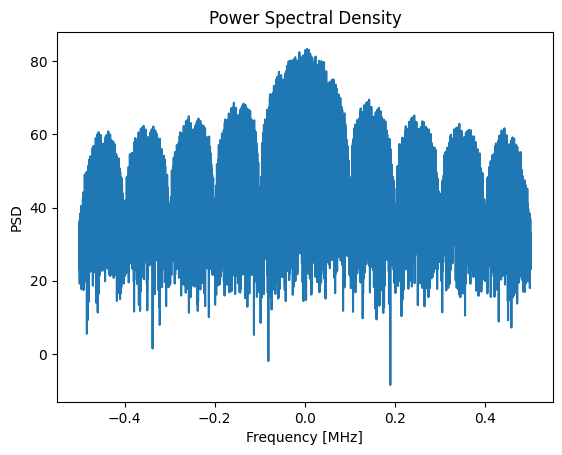

In [24]:
# Calculate power spectral density 
psd = np.abs(np.fft.fftshift(np.fft.fft(OFDM_RX)))**2
psd_dB = 10*np.log10(psd)
f_pow = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot freq domain
plt.figure(1)
plt.plot(f_pow/int(sample_rate), psd_dB) #i changed 1e6 to sample_rate, idk if right
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.title("Power Spectral Density")
plt.show()

In [25]:
# channel correction

# take first fully received data packet
OFDM_RX_data_CP = OFDM_RX_shifted[preamble_length:preamble_length+(num_packets*len(OFDM_CP[0]))*sps]
print(np.shape(OFDM_RX_shifted))

# serial to parallel
OFDM_RX_data_reshape = OFDM_RX_data_CP.reshape(num_packets, (N+CP_length)*sps)
print(np.shape(OFDM_RX_data_reshape))


OFDM_RX_data = np.zeros((num_packets, N*sps), dtype = complex)
OFDM_RX_freq = np.zeros((num_packets, N), dtype = complex)
OFDM_RX_corr = np.zeros((num_packets, N), dtype = complex)

#remove cyclic prefix from received data 
for i in range(num_packets):
    OFDM_RX_data[i] = OFDM_RX_data_reshape[i][CP_length*sps:]


# change samples back to symbols using slice
OFDM_RX_data_no_sps = OFDM_RX_data[::,::sps]

# FFT data (time-->frequency)
OFDM_RX_freq = np.fft.fft2(OFDM_RX_data_no_sps)

# correct the channel
for i in range(num_packets):
    OFDM_RX_corr[i] = OFDM_RX_freq[i] / Hest



#remove null tones
OFDM_received_data = np.zeros((num_packets, N), dtype=complex)
OFDM_received_data = np.delete(OFDM_RX_corr, [0,31,32,33], axis=1)

# #check
# print("OFDM received data", OFDM_received_data)
# print("OFDM original data", QAM_reshaped)

(6533,)
(1, 720)


C:\Users\Esthe\AppData\Local\Temp\ipykernel_14788\2214822620.py:29: RuntimeWarning: invalid value encountered in divide
  OFDM_RX_corr[i] = OFDM_RX_freq[i] / Hest


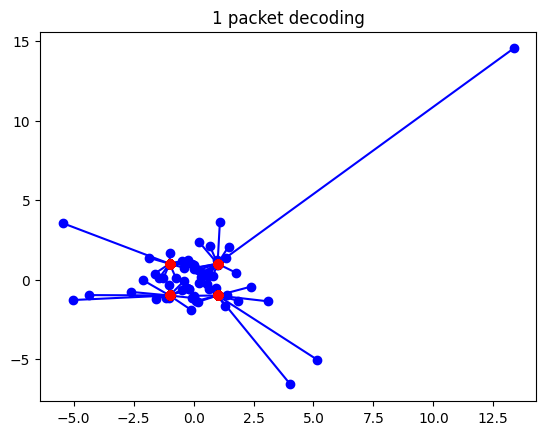

In [26]:
#use nearest neighbor decision to map received data to QAM constellation points

def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

for i in range(num_packets):
    PS_est, hardDecision = Demapping(OFDM_received_data)

hardDecision = hardDecision.reshape(num_packets,N-K)

for i in range(num_packets):
    plt.figure()
    for qam, hard in zip(OFDM_received_data[i], hardDecision[i]):
        plt.title(str(i+1)+ " packet decoding")
        plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
        plt.plot(hardDecision.real, hardDecision.imag, 'ro')
    

In [16]:
# convert bits parallel to serial
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)


print(bits_est)
print(bits)
# calculate bit error rate
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))


[1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0
 0 1 0 0 0 0 1 0 0]
[1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0
 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0
 0 1 0 0 0 0 1 0 0]
Obtained Bit error rate:  0.0
